In [1]:
import sys
sys.path.append("./attention-module/MODELS")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
# Pulled offical module into my aws sagemaker ai lab space - then later wrote myself from paper.
from cbam import CBAM
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torchvision.models.resnet import BasicBlock

In [5]:
# BasicBlock taken from Resnet Paper https://arxiv.org/pdf/1512.03385

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.cbam1 = CBAM(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.cbam2 = CBAM(128)

        self.block_128 = self.make_big_block(128, count=10)
        self.block_256 = self.make_big_block(256, count=11)
        self.convf = nn.Conv2d(512, 512, 3, padding=1)


      
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc1 = nn.Linear(512, 200)
        self.dropout = nn.Dropout(0.5)

    def make_big_block(self, channel_count, count = 3, kernel_size = 3):
        ordering = []
        downsample = nn.Sequential(
            nn.Conv2d(channel_count, channel_count*2, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(channel_count*2),
        )
        for i in range(count):
            if i != count - 1:
                ordering.append(BasicBlock(channel_count, channel_count))
                ordering.append(nn.BatchNorm2d(channel_count))
            else:
                ordering.append(BasicBlock(channel_count, channel_count*2, stride=2, downsample=downsample))
                ordering.append(CBAM(channel_count*2))

        return nn.Sequential(*ordering)

    def make_non_trans_big_block(self, channel_count, count = 3, kernel_size = 3):
        ordering = []

        for i in range(count):
            ordering.append(BasicBlock(channel_count, channel_count))
            ordering.append(nn.BatchNorm2d(channel_count))

        return nn.Sequential(*ordering)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        #x = self.cbam1(x)
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        #x = self.cbam2(x)
        x = self.pool(x)
        x = self.block_128(x)
        x = self.block_256(x)
        x = self.pool(x)
        x = self.convf(x)
        x = self.pool(x)
        x = self.dropout(x)
        x = self.adaptive_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


size of validation dataset 300


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 0 Training Loss 5.312652823545659. Validation Loss 5.312958259582519 Accuracy 0.3333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 1 Training Loss 5.2416835112616935. Validation Loss 5.199246025085449 Accuracy 0.6666666666666666


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 2 Training Loss 5.02931422336419. Validation Loss 4.917151463826498 Accuracy 1.3333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 3 Training Loss 4.85125782869136. Validation Loss 4.849535414377848 Accuracy 2.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 4 Training Loss 4.709753166134416. Validation Loss 4.748739153544108 Accuracy 3.3333333333333335


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 5 Training Loss 4.5554490747642715. Validation Loss 4.527950191497803 Accuracy 6.333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 6 Training Loss 4.374336336971292. Validation Loss 4.409046726226807 Accuracy 3.6666666666666665


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 7 Training Loss 4.20884866357729. Validation Loss 4.371510842641195 Accuracy 6.333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 8 Training Loss 4.069691017547489. Validation Loss 4.256689993540446 Accuracy 7.333333333333333


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 9 Training Loss 3.903003499513766. Validation Loss 4.061723639170329 Accuracy 9.333333333333334


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 10 Training Loss 3.7611391822371436. Validation Loss 4.003629131317139 Accuracy 12.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 11 Training Loss 3.6362468638585916. Validation Loss 4.033761908213298 Accuracy 11.666666666666666


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 12 Training Loss 3.468130018320007. Validation Loss 3.9601424662272136 Accuracy 10.333333333333334


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 13 Training Loss 3.328719532694949. Validation Loss 3.6328123219807944 Accuracy 16.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 14 Training Loss 3.2076037223187503. Validation Loss 3.5708271344502767 Accuracy 20.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 15 Training Loss 3.0892661343049617. Validation Loss 4.097987047831217 Accuracy 21.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 16 Training Loss 3.003326838670549. Validation Loss 23.776814727783204 Accuracy 17.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 17 Training Loss 2.8965734203614644. Validation Loss 4.102527535756429 Accuracy 15.666666666666666


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 18 Training Loss 2.7589544811958926. Validation Loss 5.831182327270508 Accuracy 22.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 19 Training Loss 2.6560926624964027. Validation Loss 15.78397830327352 Accuracy 18.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 20 Training Loss 2.5786984788354004. Validation Loss 2643207.4157961784 Accuracy 21.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 21 Training Loss 2.4537685356267427. Validation Loss 38.277584355672204 Accuracy 24.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 22 Training Loss 2.350859784728232. Validation Loss 43.51629656473796 Accuracy 24.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 23 Training Loss 2.2744743468931445. Validation Loss 3.223931509653727 Accuracy 27.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 24 Training Loss 2.1550223646475466. Validation Loss 11.197328364054362 Accuracy 27.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 25 Training Loss 2.051792472129878. Validation Loss 50.915158933003745 Accuracy 26.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 26 Training Loss 1.95587820222933. Validation Loss 29.2639879099528 Accuracy 28.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 27 Training Loss 1.8812509738314473. Validation Loss 694.6504796346029 Accuracy 20.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 28 Training Loss 1.7774975242470707. Validation Loss 69.30723879496257 Accuracy 27.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 29 Training Loss 1.7236172329303379. Validation Loss 12.582088432312013 Accuracy 33.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 30 Training Loss 1.682789856607888. Validation Loss 22.85630304972331 Accuracy 29.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 31 Training Loss 1.7102172442557815. Validation Loss 5622.596155649821 Accuracy 22.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 32 Training Loss 1.5846117830376982. Validation Loss 14.462484722137452 Accuracy 30.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 33 Training Loss 1.3952788848562077. Validation Loss 4.877312208811442 Accuracy 30.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 34 Training Loss 1.5167752480900494. Validation Loss 3.5048145802815753 Accuracy 29.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 35 Training Loss 1.6165081573277973. Validation Loss 51.853301474253335 Accuracy 24.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 36 Training Loss 1.4115590021657993. Validation Loss 3.379562651316325 Accuracy 34.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 37 Training Loss 1.1831200662980719. Validation Loss 3.5087829653422036 Accuracy 30.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 38 Training Loss 1.09167740145691. Validation Loss 89825.99528008144 Accuracy 30.333333333333332


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 39 Training Loss 0.99254665028894. Validation Loss 78613.29823714575 Accuracy 33.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 40 Training Loss 0.9479286921288116. Validation Loss 43691.584248956045 Accuracy 35.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 41 Training Loss 0.8972880468060354. Validation Loss 3.4621554120381672 Accuracy 33.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 42 Training Loss 0.842243852555061. Validation Loss 3.6363511149088543 Accuracy 30.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 43 Training Loss 0.8711073731471666. Validation Loss 3.7185690879821776 Accuracy 30.666666666666668


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 44 Training Loss 0.935875642077731. Validation Loss 3.3910895729064943 Accuracy 34.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 45 Training Loss 0.768492177029346. Validation Loss 3.558432000478109 Accuracy 34.333333333333336


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 46 Training Loss 0.7393978607415902. Validation Loss 3.5898799896240234 Accuracy 34.666666666666664


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 47 Training Loss 0.6787861161873472. Validation Loss 3.4114856910705567 Accuracy 35.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 48 Training Loss 0.6660912465245253. Validation Loss 4.215090160369873 Accuracy 33.0


  0%|          | 0/178 [00:00<?, ?it/s]

Epoch 49 Training Loss 0.6313392681785747. Validation Loss 3.7922458902994793 Accuracy 32.666666666666664
Test Accuracy: 36 % 


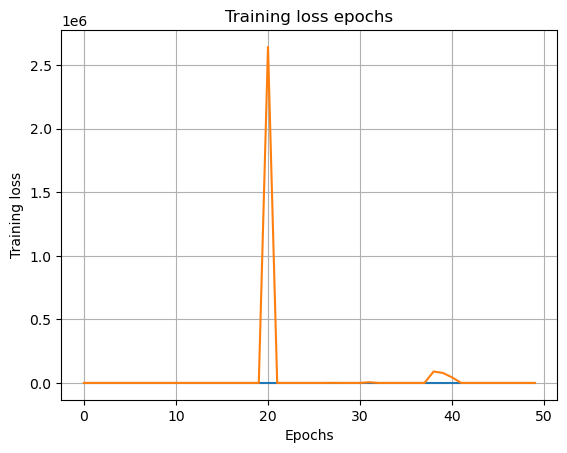

In [6]:
# I looked up how to bold words so I could make test accuracy more visible in output
bold_start = "\033[1m"
bold_end = "\033[0m"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])


batch_size = 32
epochs = 50
num_classes = 200

def create_list_of_epochs(epochs):
    list_of_epochs = []
    for epoch in range(epochs):
        list_of_epochs.append(epoch)
    return list_of_epochs


train_dataset = datasets.ImageFolder("CUB_200_2011_reorganized/train",
                                     transform=train_transform)
length_of_inital_train_dataset = int(0.95 * len(train_dataset))
length_of_validation_dataset = len(train_dataset) - length_of_inital_train_dataset
train_dataset, validation_dataset = random_split(
    train_dataset, [length_of_inital_train_dataset, length_of_validation_dataset])
validation_dataset.transform = transform
test_dataset = datasets.ImageFolder("CUB_200_2011_reorganized/test",
                                    transform=transform)

print(f"size of validation dataset {len(validation_dataset)}")

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
validation_loader = DataLoader(validation_dataset, shuffle=False, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

model = MyNet()
model = nn.DataParallel(model)
model = model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
#scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-6)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

validation_loss_tracker = []

list_of_training_loss = []

#model.summary()
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        prediction = model(images)
        loss = loss_function(prediction, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    training_loss_for_epoch = running_loss/len(train_dataset)
    list_of_training_loss.append(training_loss_for_epoch)

    model.eval()
    validation_loss = 0
    correct_for_validation = 0
    total_for_validation = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            validation_loss += loss.item() * images.size(0)
            nothing, predicted = torch.max(outputs.data, 1)
            total_for_validation += labels.size(0)
            correct_for_validation += (predicted == labels).sum().item()
    avg_val_loss = validation_loss / len(validation_dataset)
    validation_loss_tracker.append(avg_val_loss)
    accuracy = 100 * correct_for_validation / total_for_validation
    print(f"Epoch {epoch} Training Loss {training_loss_for_epoch}. Validation Loss {avg_val_loss} Accuracy {accuracy}")
    #scheduler.step()


correct = 0
total = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        model.eval()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        nothing, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'{bold_start}Test Accuracy: {100 * correct // total} % {bold_end}')


list_of_epochs = create_list_of_epochs(epochs)

plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.title("Training loss epochs")
plt.plot(list_of_epochs, list_of_training_loss, label="Training Loss")
plt.plot(list_of_epochs, validation_loss_tracker, label="Validation loss")
plt.grid(True)
plt.show()
